<a id="0"></a>
<font color="lightseagreen" size=+2.5><b>Data</b></font>

#### Stroke Prediction Dataset

**Context**

- According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

**Attribute Information**
1. **id**: unique identifier

2. **gender**: "Male", "Female" or "Other"

3. **age**: age of the patient

4. **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5. **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6. **ever_married**: "No" or "Yes"

7. **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8. **Residence_type**: "Rural" or "Urban"

9. **avg_glucose_level**: average glucose level in blood

10. **bmi**: body mass index

11. **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12. **stroke**: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

<a id="1"></a>
<font color="lightseagreen" size=+2.5><b>Exploratory Data Analysis</b></font>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 



from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset.csv')
df=df.drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


<a id="4"></a>
<font color="lightseagreen" size=+1.5><b>Target Variable</b></font>

In [4]:
y = df['stroke']
print(f'Percentage of patient had a stroke: % {round(y.value_counts(normalize=True)[1]*100,2)} --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a stroke: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} patient)')

Percentage of patient had a stroke: % 4.87 --> (249 patient)
Percentage of patient did not have a stroke: % 95.13 --> (4861 patient)


Almost 95% of patients (4,861) did not have a stroke, while only 5% (249 patients) had a stroke, indicating we have imbalanced data.

In [5]:
fig = px.histogram(df, x="stroke", title='Stroke', width=400, height=400)
fig.show()

<a id="6"></a>
<font color="lightseagreen" size=+1.5><b>Decide the Metric</b></font>

- For this imbalanced binary classification problem (95% vs 5%), our first step is choosing the right evaluation metric. AUC-ROC is the best choice since it combines precision and recall. Due to the skewed target distribution, we'll use StratifiedKFold for splitting. Note that accuracy is not suitable for highly imbalanced data like this.

<a id="7"></a>
<font color="lightseagreen" size=+1.5><b>Missing Values</b></font>

In [6]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
bmi,201,0.039335
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
smoking_status,0,0.000000


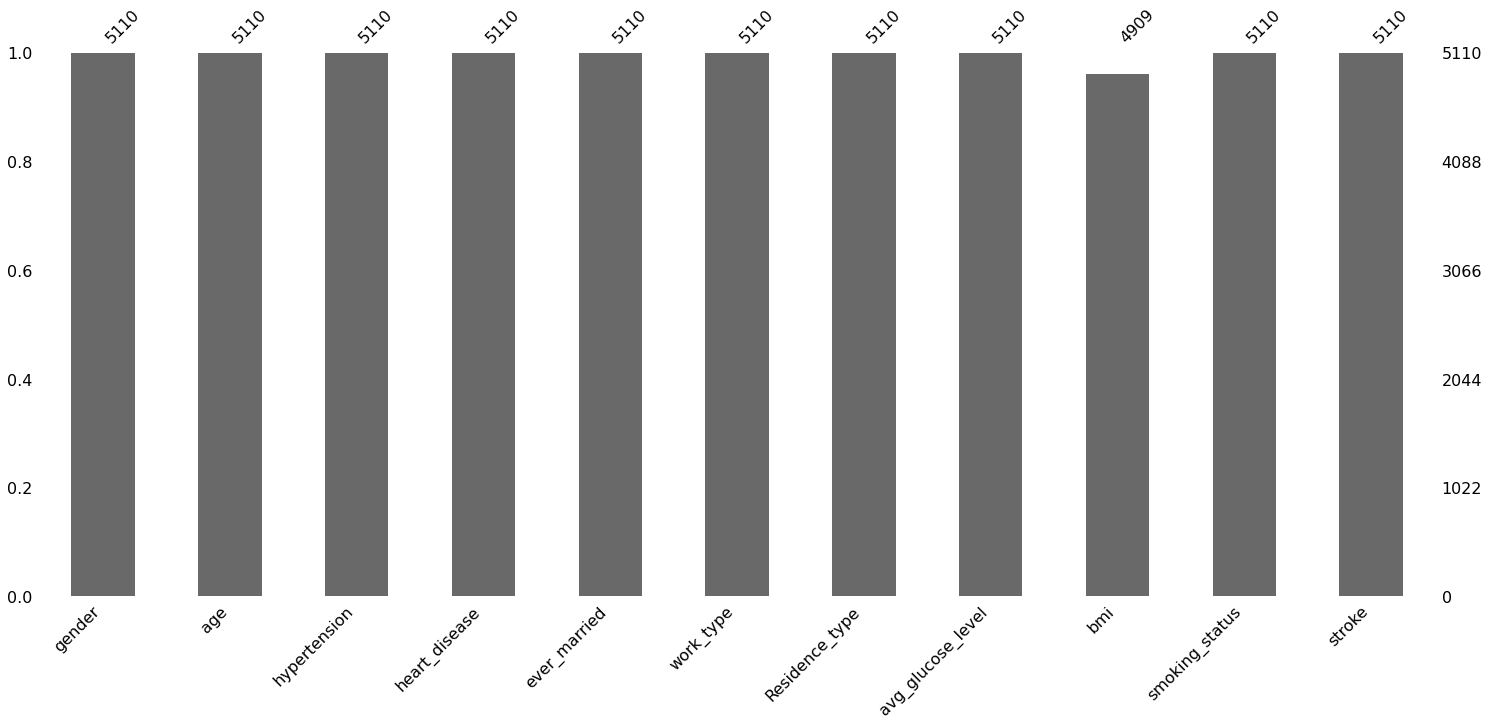

In [7]:
msno.bar(df);

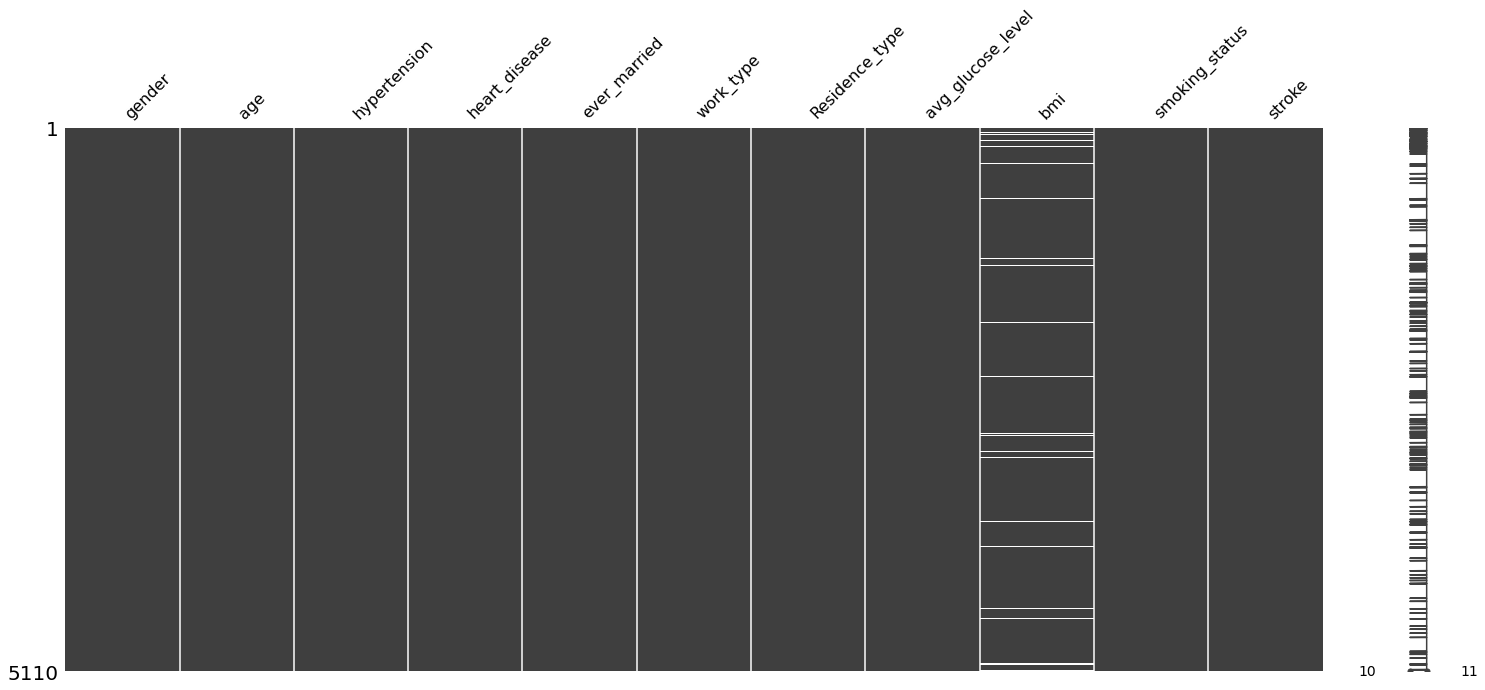

In [8]:
msno.matrix(df);

The dataset contains approximately 4% missing values in the 'bmi' column which appear to be randomly distributed - we'll handle these missing values using a pipeline during the modeling phase.

In [9]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

numerical = ['age','avg_glucose_level', 'bmi']

<a id="8"></a>
<font color="lightseagreen" size=+1.5><b>Numerical Features</b></font>

In [10]:
df[numerical].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


### **Skewness**

In [11]:
df[numerical].skew()

age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.055340
dtype: float64

- Based on the result, age has slight left skew, other two features have right tail, positively skewed shape distribution.

### **Univariate Analysis**

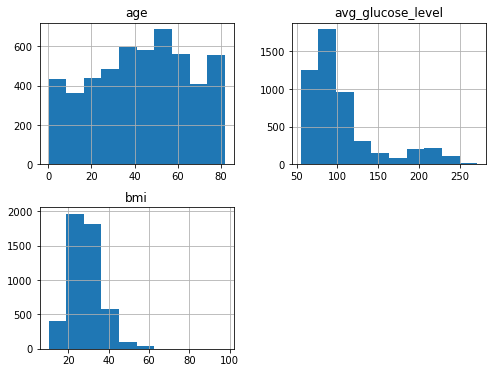

In [12]:
df[numerical].hist(figsize=(8,6));

<a id="9"></a>
<font color="lightseagreen" size=+1.5><b>Categorical Features</b></font>

#### **Gender**

In [13]:
print (f'{round(df["gender"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="gender", title='Gender', width=400, height=400)
fig.show()

Female    58.59
Male      41.39
Other      0.02
Name: gender, dtype: float64


#### Hypertension

In [14]:
print (f'{round(df["hypertension"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="hypertension", title='hypertension', width=400, height=400)
fig.show()

0    90.25
1     9.75
Name: hypertension, dtype: float64


We have 498 patient with hypertension which represents at raound 10 % of the sample.

#### Heart Disease

In [15]:
print (f'{round(df["heart_disease"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="heart_disease", title='heart_disease', width=400, height=400)
fig.show()

0    94.6
1     5.4
Name: heart_disease, dtype: float64


We have 276 patient with heart disease which is 5.4 % of the sample.

#### Married

In [16]:
print (f'{round(df["ever_married"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="ever_married", title='ever_married', width=400, height=400)
fig.show()

Yes    65.62
No     34.38
Name: ever_married, dtype: float64


3353 people have been married and 1757 people are not married before.

#### Work Type

In [17]:
print (f'{round(df["work_type"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="work_type", title='work_type', width=400, height=400)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

Private          57.24
Self-employed    16.03
children         13.44
Govt_job         12.86
Never_worked      0.43
Name: work_type, dtype: float64


- 2925 people work in the private sector.
- 819 people are self-employed
- 657 people work at the government job.


#### Residence Type

In [18]:
print (f'{round(df["Residence_type"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="Residence_type", title='Residence_type', width=400, height=400)
fig.show()

Urban    50.8
Rural    49.2
Name: Residence_type, dtype: float64


- 2596 people live in the urban area
- 2514 people live in the rural area

#### Smoking

In [19]:
print (f'{round(df["smoking_status"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="smoking_status", title='smoking_status', width=400, height=400)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

never smoked       37.03
Unknown            30.22
formerly smoked    17.32
smokes             15.44
Name: smoking_status, dtype: float64


- 1892 people are never smoked
- 789 people smoke

<a id="10"></a>
<font color="lightseagreen" size=+1.5><b>Bivariate Analysis</b></font>


#### **Hypertension & Stroke**

In [20]:
print (f'A person with hypertension has a probability of {round(df[df["hypertension"]==1]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person without hypertension has a probability of  {round(df[df["hypertension"]==0]["stroke"].mean()*100,2)} % get a stroke')



A person with hypertension has a probability of 13.25 % get a stroke

A person without hypertension has a probability of  3.97 % get a stroke


In [21]:
fig = px.histogram(df, x="hypertension", color="stroke",width=400, height=400)
fig.show()

- As we have seen, stroke probability for those who has hypertension are quite different than for those who don't.
- %13.2 and %3.9 respectively
- It means that **person with hypertension are almost 3.3 time more likely to get stroke than the ones who don't have hypertension**.

#### **Gender & Stroke**

In [22]:
print (f'A female person has a probability of {round(df[df["gender"]=="Female"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A male person has a probability of {round(df[df["gender"]=="Male"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person from  the other category of gender has a probability of {round(df[df["gender"]=="Other"]["stroke"].mean()*100,2)} % get a stroke')


A female person has a probability of 4.71 % get a stroke

A male person has a probability of 5.11 % get a stroke

A person from  the other category of gender has a probability of 0.0 % get a stroke


In [23]:
fig = px.histogram(df, x="gender", color="stroke",width=400, height=400)
fig.show()

- **Male compare to female are more likelyto get stroke, but difference between female and male is very small.**

#### **Heart Disease & Stroke**

In [24]:
print (f'A person with heart disease has a probability of {round(df[df["heart_disease"]==1]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person without heart disease has a probability of {round(df[df["heart_disease"]==0]["stroke"].mean()*100,2)} % get a stroke')


A person with heart disease has a probability of 17.03 % get a stroke

A person without heart disease has a probability of 4.18 % get a stroke


In [25]:
fig = px.histogram(df, x="heart_disease", color="stroke",width=400, height=400)
fig.show()

As we have seen, stroke probability for those who have heart disease (17.03%) is quite different from those who don't (4.18%). This means that a person with heart disease is 4.07 times more likely to get a stroke than someone without heart disease.

#### **Married & Stroke**

In [26]:
print (f'A person married (or married before) has a probability of {round(df[df["ever_married"]=="Yes"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person never married has a probability of {round(df[df["ever_married"]=="No"]["stroke"].mean()*100,2)} % get a stroke')


A person married (or married before) has a probability of 6.56 % get a stroke

A person never married has a probability of 1.65 % get a stroke


In [27]:
fig = px.histogram(df, x="ever_married", color="stroke",width=400, height=400)
fig.show()

As we have seen, stroke probability for those who have marriage history (6.56%) is quite different than for those who don't (1.65%). This means that a person who is married (or was married before) is 5.7 times more likely to get a stroke than someone who has never been married.

#### **Work Type & Stroke**

In [28]:
print (f'A person with private work type has a probability of {round(df[df["work_type"]=="Private"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'Self-employed person has a probability of {round(df[df["work_type"]=="Self-employed"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person with a goverment job has a probability of {round(df[df["work_type"]=="Govt_job"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A child has a probability of {round(df[df["work_type"]=="children"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person never worked has a probability of {round(df[df["work_type"]=="Never_worked"]["stroke"].mean()*100,2)} % get a stroke')

A person with private work type has a probability of 5.09 % get a stroke

Self-employed person has a probability of 7.94 % get a stroke

A person with a goverment job has a probability of 5.02 % get a stroke

A child has a probability of 0.29 % get a stroke

A person never worked has a probability of 0.0 % get a stroke


In [29]:
fig = px.histogram(df, x="work_type", color="stroke",width=600, height=600)
fig.show()

- Looking at the work type data, self-employed individuals have a higher probability of experiencing a stroke compared to other work types. Meanwhile, those with private sector jobs and government positions show similar probabilities of stroke occurrence.

#### **Residence Type & Stroke**

In [30]:
print (f'A person, who lives in urban area, has a probability of {round(df[df["Residence_type"]=="Urban"]["stroke"].mean()*100,2)} %  get a stroke')

print()

print (f'A person, who lives in rural area, has a probability of {round(df[df["Residence_type"]=="Rural"]["stroke"].mean()*100,2)} % get a stroke')


A person, who lives in urban area, has a probability of 5.2 %  get a stroke

A person, who lives in rural area, has a probability of 4.53 % get a stroke


In [31]:
fig = px.histogram(df, x="Residence_type", color="stroke",width=400, height=400)
fig.show()

- As seen, there is not much difference between person residence type.
- Person who lives in rural area slightly has more probablity to get sroke than a person who lives in rural area. Difference is small.

#### **Smoking & Stroke**

In [32]:
print (f'A formerly smoked person has a probability of {round(df[df["smoking_status"]=="formerly smoked"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person never smoked has a probability of {round(df[df["smoking_status"]=="never smoked"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person smokes has a probability of {round(df[df["smoking_status"]=="smokes"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person whom smoking history is not known,has a probability of {round(df[df["smoking_status"]=="Unknown"]["stroke"].mean()*100,2)} % get a stroke')

print()

A formerly smoked person has a probability of 7.91 % get a stroke

A person never smoked has a probability of 4.76 % get a stroke

A person smokes has a probability of 5.32 % get a stroke

A person whom smoking history is not known,has a probability of 3.04 % get a stroke



In [33]:
fig = px.histogram(df, x="smoking_status", color="stroke",width=600, height=600)
fig.show()

- Analysis shows there are differences in stroke probability based on smoking habits. A formerly smoked person has a 1.66 times higher probability of getting a stroke compared to someone who never smoked. Currently smoking individuals have a 1.11 times higher probability than those who never smoked. Overall, there is a relatively small difference in stroke probability between smokers and non-smokers.

#### **Metrics of Importance**

The mutual information score measures the degree of dependency between a categorical variable and the target variable. When mutual information values are higher, it indicates a stronger degree of dependence between the variables. A higher mutual information score suggests we can make better predictions about the target variable using that categorical feature.

In [34]:
from sklearn.metrics import mutual_info_score
def cat_mut_inf(series):
    return mutual_info_score(series, df['stroke']) 

df_cat = df[categorical].apply(cat_mut_inf) 
df_cat = df_cat.sort_values(ascending=False).to_frame(name='mutual_info_score') 
df_cat

,mutual_info_score
ever_married,0.006950
work_type,0.006825
hypertension,0.005976
heart_disease,0.005897
smoking_status,0.002750
Residence_type,0.000120
gender,0.000051


- As seen above, most of the categorical variables, almost no effect on the target variable.

### Correlation Matrix & Scatter Plots

In [35]:
df[numerical].corr()

,age,avg_glucose_level,bmi
age,1.000000,0.238171,0.333398
avg_glucose_level,0.238171,1.000000,0.175502
bmi,0.333398,0.175502,1.000000


- There is very small positive correlation between numerical features.

In [36]:
df.groupby('stroke')[numerical].mean()

,age,avg_glucose_level,bmi
stroke,,,
0,41.971545,104.795513,28.823064
1,67.728193,132.544739,30.471292


In [37]:
df[['age','avg_glucose_level','bmi','stroke']].corr()

,age,avg_glucose_level,bmi,stroke
age,1.000000,0.238171,0.333398,0.245257
avg_glucose_level,0.238171,1.000000,0.175502,0.131945
bmi,0.333398,0.175502,1.000000,0.042374
stroke,0.245257,0.131945,0.042374,1.000000


- The data shows that as age increases, the mean stroke score also increases. There are notable differences in average glucose level scores between people who have had a stroke versus those who have not. BMI mean scores remain relatively similar between the two groups. Overall, the correlations between these variables and the target variable (stroke) are quite weak.

# Visualization

#### **Age & BMI** 

In [38]:
fig = px.scatter(df, x='age', y='bmi', title='Age & BMI ',color='stroke', hover_data = df[['stroke']])
fig.show()

#### **Age & Average Glucose Level**

In [39]:
fig = px.scatter(df, y='avg_glucose_level', x='age', title='Age & Average Glucose Level',color='stroke', hover_data = df[['stroke']])
fig.show()

#### **Average Glucose Level & BMI**

In [40]:
fig = px.scatter(df, y='avg_glucose_level', x='bmi', title='Average Glucose Level & BMI ',color='stroke', hover_data = df[['stroke']])
fig.show()

<a id="11"></a>
<font color="lightseagreen" size=+1.5><b>Insights from the Exploratory Data Analysis</b></font>

- Age and target variable weak positive relationship (almost .25).
- Average glucose level's mean scores on the target have differences between a person who has a stroke or not. But this differences are small.
- BMI does not have any significant relationship with the target variable. 
- A person with hypertension are almost 3.3 time more likely to get stroke than the ones who don't have hypertension.
- Male compare to female are more likelyto get stroke, but difference between female and male is very small.
- A person with heart diease are 4.07 times more likely to get stroke than the ones who don't have heart disease.
- A person is married(or married before) are 5.7 times more likely to get stroke than the ones who don't have marriage history.
- Self employed person has more probability to get stroke than other work type. Be carefull !!!
- Person who lives in rural area slightly has more probablity to get sroke than a person who lives in rural area. Difference is small.
- It is small difference between who smokes and who does not smoke in regard to probability of getting stroke.

<a id="12"></a>
<font color="lightseagreen" size=+2.5><b>MODEL SELECTION</b></font>

<a id="13"></a>
<font color="lightseagreen" size=+1.5><b>Load the Data</b></font>


In [41]:
def load_data():
    df = pd.read_csv('dataset.csv')
    df = df.drop('id', axis=1)
    categorical = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi', 'age']
    y = df['stroke']
    X = df.drop('stroke', axis=1)
    return X, y, categorical, numerical

<a id="14"></a>
<font color="lightseagreen" size=+1.5><b>Our Evaluation Model</b></font>

In [42]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores


We will use K-fold repeated stratified cross validation with 10 folds (511 instances each) to evaluate our models. The stratified version ensures proper representation of stroke (5%) and no-stroke (95%) cases in each fold. The evaluation process will be repeated 3 times, resulting in 30 total evaluations per model, with mean and standard deviation reported. Models will be compared using the area under ROC Curve (ROC AUC) metric.

<a id="15"></a>
<font color="lightseagreen" size=+1.5><b>Baseline Model</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [43]:
def load_data():
    df = pd.read_csv('dataset.csv')
    df = df.drop('id', axis=1)
    categorical = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi', 'age']
    y = df['stroke']
    X = df.drop('stroke', axis=1)
    return X, y, categorical, numerical


def baseline_model(X, y, model):
    transformer = ColumnTransformer(transformers=[('imp', SimpleImputer(strategy='median'), numerical),
                                                ('o', OneHotEncoder(), categorical)])
    pipeline = Pipeline(steps=[('t', transformer),
                             ('p', PowerTransformer(method='yeo-johnson')),
                             ('m', model)])    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

X, y, categorical, numerical = load_data()
model = DummyClassifier(strategy='constant', constant=1)
scores = baseline_model(X, y, model)
print('Mean roc_auc: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean roc_auc: 0.500 (0.000)


<a id="16"></a>
<font color="lightseagreen" size=+1.5><b>Our Models</b></font>


In [44]:
def get_models():
    # Initialize empty lists to store models and their names
    models, names = list(), list()
    
    # Add Logistic Regression model with liblinear solver
    models.append(LogisticRegression(solver='liblinear'))    
    names.append('LR')
    
    # Add Linear Discriminant Analysis model
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    
    # Add Support Vector Machine model with scaled gamma
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    
    return models, names

<a id="17"></a>
<font color="lightseagreen" size=+1.5><b>Analyze the Models</b></font>


In [45]:
models, names = get_models()
results = []
for i in range(len(models)):
    transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(),categorical)])
    pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('m', models[i])])    
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)

The model evaluation process incorporates several preprocessing steps to address data quality issues identified during exploratory analysis. Due to the presence of missing values, which most machine learning algorithms cannot handle directly, median imputation was implemented. Categorical variables were encoded numerically using one-hot encoding, while skewed numerical features were standardized and transformed using the Yeo-Johnson method. To prevent data leakage, these preprocessing steps were encapsulated in a scikit-learn Pipeline that fits transformations on training data before applying them to test data. The pipeline enables systematic evaluation of multiple models using cross-validation, with performance metrics stored for comparative analysis. This methodical approach facilitates identification of the optimal algorithm for the given classification task, which will subsequently undergo detailed performance analysis.

<a id="18"></a>
<font color="lightseagreen" size=+1.5><b>Visualize the Results</b></font>

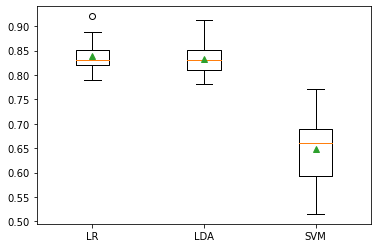

In [46]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

After getting results, we will look at each Machine Learning algorithm by using box and whisker plots.

<a id="19"></a>
<font color="lightseagreen" size=+1.5><b> Our First Model </b></font>

(5110, 10) (5110,)
>LR 0.839 (0.029)
>LDA 0.833 (0.030)
>SVM 0.649 (0.063)


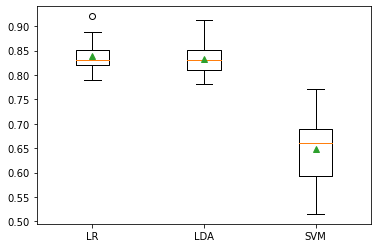

In [47]:
def load_data ():
    df = pd.read_csv('dataset.csv')
    df=df.drop('id', axis=1)
    categorical = [ 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi','age']
    y= df['stroke']
    X = df.drop('stroke', axis=1)
    return X,y,categorical, numerical


def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='liblinear'))    
    names.append('LR')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names


X,y,categorical, numerical= load_data()
print(X.shape, y.shape)

models, names = get_models()
results = list()

for i in range(len(models)):
    transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(),categorical)])
    pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('m', models[i])])    
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Analysis of the model performance reveals that logistic regression achieved marginally superior performance (AUC=0.839) compared to Linear Discriminant Analysis (AUC=0.833), though their distributions were largely comparable. While all methods demonstrated predictive capability, Support Vector Machine exhibited notably lower performance (AUC=0.649). The box and whisker plot visualization confirms these comparative model performances. Further investigation with SMOTE implementation may yield different relative performance patterns.

<a id="20"></a>
<font color="lightseagreen" size=+1.5><b> Our Second Model with SMOTE </b></font>

(5110, 10) (5110,)
>LR 0.837 (0.029)
>LDA 0.839 (0.031)
>SVM 0.766 (0.039)


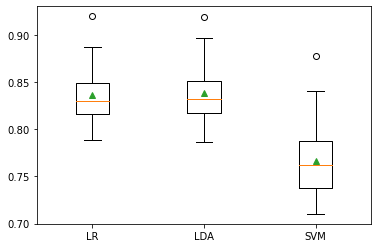

In [48]:
from imblearn.pipeline import Pipeline

def load_data ():
    df = pd.read_csv('dataset.csv')
    df=df.drop('id', axis=1)
    categorical = [ 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi','age']
    y= df['stroke']
    X = df.drop('stroke', axis=1)
    return X,y,categorical, numerical


def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='liblinear'))    
    names.append('LR')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names


X,y,categorical, numerical= load_data()
print(X.shape, y.shape)

models, names = get_models()
results = list()

for i in range(len(models)):
    transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(),categorical)])
    pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson', standardize=True)),('over', SMOTE()), ('m', models[i])])    
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

To address the class imbalance in our dataset (5% stroke vs 95% no stroke), we employed the Synthetic Minority Oversampling Technique (SMOTE). SMOTE algorithmically generates new minority class samples by interpolating between existing stroke cases using k-nearest neighbors, effectively balancing the class distribution. This technique was integrated into our second model to achieve equal representation between stroke and non-stroke classes.

Looking at the results:
There is a significant jump on the SVM (from .649 to .76), very small changes on the LR and LDA, all methods still show skill on the problem.